In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf

# local (this repo) imports
from dev import load_cleaned_russian_text_data, evaluate_model, SEED
from wordEmbeddingsLayers import wiki40_russian_embedding_layer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build RNN model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    wiki40_russian_embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dropout(rate=0.2, seed=SEED),
    tf.keras.layers.Dense(64, activation='relu'),
    layers.Dense(1),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, потому что у нас есть финальный 
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [5]:
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**7,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
)

Epoch 1/10
73/73 [==============================] - 73s 968ms/step - loss: 0.5389 - binary_accuracy: 0.7179 - recall: 0.3631 - precision: 0.6432 - val_loss: 0.3369 - val_binary_accuracy: 0.8539 - val_recall: 0.7174 - val_precision: 0.8212
Epoch 2/10
73/73 [==============================] - 58s 804ms/step - loss: 0.2945 - binary_accuracy: 0.8822 - recall: 0.8057 - precision: 0.8410 - val_loss: 0.2915 - val_binary_accuracy: 0.8786 - val_recall: 0.7930 - val_precision: 0.8342
Epoch 3/10
73/73 [==============================] - 57s 787ms/step - loss: 0.2206 - binary_accuracy: 0.9145 - recall: 0.8622 - precision: 0.8796 - val_loss: 0.4626 - val_binary_accuracy: 0.7984 - val_recall: 0.9388 - val_precision: 0.6330
Epoch 4/10
73/73 [==============================] - 61s 834ms/step - loss: 0.1945 - binary_accuracy: 0.9275 - recall: 0.9012 - precision: 0.8892 - val_loss: 0.3117 - val_binary_accuracy: 0.8851 - val_recall: 0.7643 - val_precision: 0.8748
Epoch 5/10
73/73 [==========================

# Model evaluation

Accuracy: 89.98%
Recall: 81.03%
Precision: 87.74%
F1-score: 84.25% 



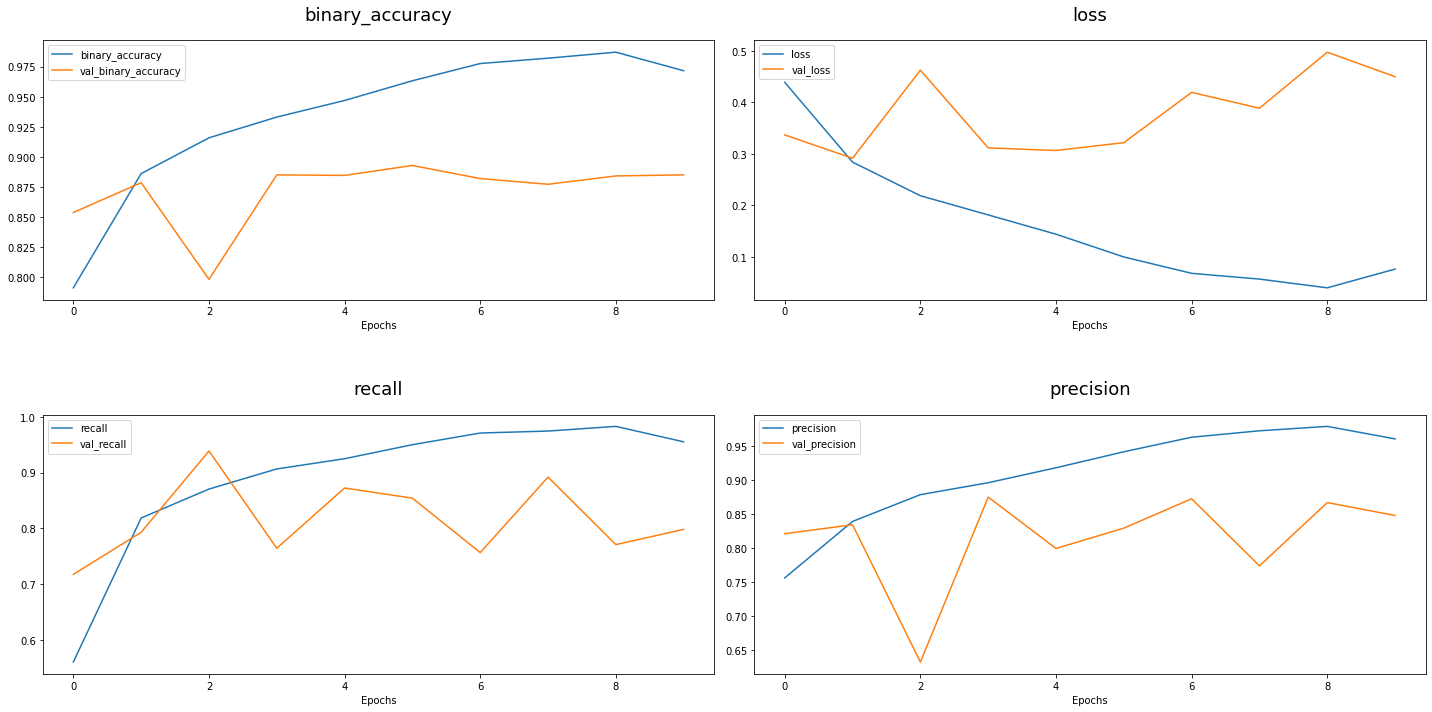

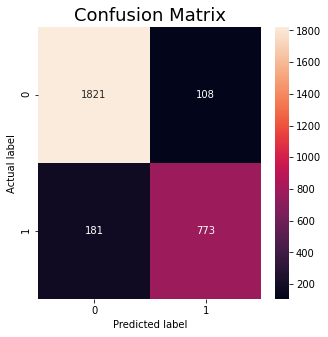

In [6]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)